In [1]:
import warnings
import importlib

warnings.filterwarnings("ignore")

from pathlib import Path
from typing import List, Optional, Union

import numpy as np
import pandas as pd

from tsururu.dataset import Pipeline, TSDataset
from tsururu.model_training.validator import HoldOutValidator
from tsururu.models.torch_based import MTGNN, StemGNN, ForecastGrapher, FourierGNN, CrossGNN, Linear
from tsururu.models.torch_based.dlinear import DLinear_NN
from tsururu.strategies import MIMOStrategy
from tsururu.transformers import (LagTransformer, SequentialTransformer,
                                  TargetGenerator, UnionTransformer, TimeToNumGenerator)

from tsururu.model_training.trainer import DLTrainer

import torch

import sys
sys.stdout = open('output.txt','wt')

torch.set_float32_matmul_precision('high')

In [2]:
def get_results(
    cv: int,
    regime: str,
    y_true: Optional[List[np.ndarray]] = None,
    y_pred: Optional[List[np.ndarray]] = None,
    ids: Optional[List[Union[float, str]]] = None,
) -> pd.DataFrame:
    def _get_fold_value(
        value: Optional[Union[float, np.ndarray]], idx: int
    ) -> List[Optional[Union[float, np.ndarray]]]:
        if value is None:
            return [None]
        if isinstance(value[idx], float):
            return value[idx]
        if isinstance(value[idx], np.ndarray):
            return value[idx].reshape(-1)
        raise TypeError(f"Unexpected value type. Value: {value}")

    df_res_dict = {}

    for idx_fold in range(cv):
        # Fill df_res_dict
        for name, value in [("y_true", y_true), ("y_pred", y_pred)]:
            df_res_dict[f"{name}_{idx_fold+1}"] = _get_fold_value(value, idx_fold)
        if regime != "local":
            df_res_dict[f"id_{idx_fold+1}"] = _get_fold_value(ids, idx_fold)

    # Save datasets to specified directory
    df_res = pd.DataFrame(df_res_dict)
    return df_res

In [3]:
def expand_val_with_train(train_data, val_data, id_column, date_column, history):
    L_split_data = train_data[date_column].values[(len(train_data) - history)]
    L_last_train_data = train_data[train_data[date_column] >= L_split_data]
    val_data_expanded = pd.concat((L_last_train_data, val_data))
    val_data_expanded = val_data_expanded.sort_values([id_column, date_column]).reset_index(
        drop=True
    )
    return val_data_expanded


def expand_test_with_val_and_train(
    train_data, val_data, test_data, id_column, date_column, history
):
    unqiue_id_cnt = val_data[id_column].nunique()
    L_split_data = val_data[date_column].values[
        (
            (len(val_data) - history)
            if (len(val_data) // val_data[id_column].nunique() - history) > 0
            else 0
        )
    ]
    L_last_val_data = val_data[val_data[date_column] >= L_split_data]
    if len(val_data) // unqiue_id_cnt - history < 0:
        if (len(train_data) - (history - len(L_last_val_data) / unqiue_id_cnt)) > 0:
            L_split_data = train_data[date_column].values[
                (
                    len(train_data) // unqiue_id_cnt
                    - (history - len(L_last_val_data) // unqiue_id_cnt)
                )
            ]
        else:
            L_split_data = 0
        L_last_train_data = train_data[train_data[date_column] >= L_split_data]
        test_data_expanded = pd.concat((L_last_train_data, L_last_val_data, test_data))
    else:
        test_data_expanded = pd.concat((L_last_val_data, test_data))
    test_data_expanded = test_data_expanded.sort_values([id_column, date_column]).reset_index(
        drop=True
    )
    return test_data_expanded


def get_train_val_test_datasets(dataset_path, columns_params, train_size, test_size, history):
    data = pd.read_csv(dataset_path)

    date_column = columns_params["date"]["columns"][0]
    id_column = columns_params["id"]["columns"][0]

    if dataset_path.parts[-1] in ["ETTh1.csv", "ETTh2.csv", "ETTm1.csv", "ETTm2.csv"]:
        train_val_split_data = "2017-06-25 23:00:00"
        val_test_slit_data = "2017-10-23 23:00:00"
    else:
        train_val_split_data = data[date_column].values[
            int(data[date_column].nunique() * train_size)
        ]
        val_test_slit_data = data[date_column].values[
            int(data[date_column].nunique() * (1 - test_size))
        ]

    train_data = data[data[date_column] <= train_val_split_data]
    val_data = data[
        (data[date_column] > train_val_split_data) & (data[date_column] <= val_test_slit_data)
    ]
    test_data = data[data[date_column] > val_test_slit_data]
    val_data = expand_val_with_train(train_data, val_data, id_column, date_column, history)
    test_data_expanded = expand_test_with_val_and_train(
        train_data, val_data, test_data, id_column, date_column, history
    )

    # train, val and test TSDataset initialization
    train_dataset = TSDataset(
        data=train_data,
        columns_params=columns_params,
        print_freq_period_info=True,
    )

    val_dataset = TSDataset(
        data=val_data,
        columns_params=columns_params,
    )

    test_dataset = TSDataset(
        data=test_data_expanded,
        columns_params=columns_params,
    )

    return train_dataset, val_dataset, test_dataset

In [4]:
# import pandas as pd
# import numpy as np

# df = pd.read_csv("datasets/global/traffic_raw.csv")

# df = df.loc[:2400]
# df = df.rename({"OT": 861}, axis=1)

# new_df  = pd.DataFrame(columns=["date", "id", "value"])

# for col in df.columns[1:]:
#     temp_df = pd.DataFrame(columns=["date", "id", "value"])
#     temp_df["date"] = df["date"].copy()
#     temp_df = temp_df.assign(id=int(col))
#     temp_df["value"] = df[col].copy()
#     new_df = pd.concat((new_df, temp_df), axis=0)

# new_df

## Initialize TSDataset, Pipeline, Model, Validator, Strategy

### TSDataset

In [5]:
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
history = 96

df_path = Path("datasets/global/traffic.csv")

columns_params = {
    "target": {
        "columns": ["value"],
        "type": "continious",
    },
    "date": {
        "columns": ["date"],
        "type": "datetime",
    },
    "id": {
        "columns": ["id"],
        "type": "categorical",
    }
}

train_dataset, val_dataset, test_dataset = get_train_val_test_datasets(
    df_path, columns_params, TRAIN_SIZE, TEST_SIZE, history
)

### Pipeline

In [6]:
pipeline_params = {
    "target": {
        "columns": ["value"],
        "features": {
            "StandardScalerTransformer":
                {
                    "transform_target": True, 
                    "transform_features": True
                },
            "LagTransformer": {"lags": 96},
        },
    },
    # "date": {
    #     "columns": ["date"],
    #     "features": {
    #         "DateSeasonsGenerator": {
    #             # Use seasonality features from the date column as 
    #             # features with datetime lags
    #             # Possible values: [
    #             #    "y": year, "m": month, "d": day, 
    #             #    "wd": weekday, "doy": dayofyear,
    #             #    "hour": hour, "min": minute, "sec": second, 
    #             #    "ms": microsecond,  "ns": nanosecond
    #             # ]
    #             "seasonalities": ['y', 'm'], 
    #             # Use date from target point to make datetime features
    #             "from_target_date": True,
    #         },
    #         "LagTransformer": {"lags": 168}
    #     },
    # },

}

pipeline = Pipeline.from_dict(pipeline_params, multivariate=True)

### Trainer

In [7]:
# Configure the model parameters
# model = MTGNN
# model_params = {
#     "num_nodes": 8, "in_dim": 1, "subgraph_size": 8, "strategy": 'unidirected', 
#     "gcn_true": True, "gcn_depth": 2, "node_dim": 40, "dilation_exp": 1, 
#     "conv_channels": 32, "residual_channels": 32, "skip_channels": 64, 
#     "end_channels": 128, "layers": 3, "propalpha": 0.05, "tanhalpha": 3, 
#     "layer_norm_affine": True
# }

# model = StemGNN
# model_params = {
#     "num_nodes": 8, "multi_layer": 5, "stack_cnt": 2, 
#     "dropout_rate": 0.5, "leaky_rate": 0.2
# }

# model = ForecastGrapher
# model_params = {
#     "num_nodes": 8, "node_dim": 128, "use_norm": True, "e_layers": 2,
#     "individual": False, "z": 32, "k": 3, "gcn_depth": 2, 
#     "dropout": 0.05, "strategy": "graph_wavenet"
# }

# model = FourierGNN
# model_params = {
#     "embed_size" : 64,  
#     "hidden_size" : 64
# }

# model = CrossGNN
# model_params = {
#     "enc_in": 862, "tk": 10, "scale_number": 4, "use_tgcn": True,
#     "use_ngcn": True, "individual": False, "dropout": 0.05, "tvechidden": 1,
#     "nvechidden": 1, "d_model": 64, "e_layers": 2, "anti_ood": True
# }

# model = DLinear_NN
# model_params = {"moving_avg": 7, "individual": False, "enc_in": None}

model = Linear
model_params = {"enc_in": 862, "d_model": 862, "individual": False, "norm": True, "mix": False}

In [8]:
validation = HoldOutValidator
validation_params = {"validation_data": val_dataset}

def get_lr_lambda(factor = 0.1, n_warmup = 5, gamma = 0.9):
    def lr_lambda(n):
        if n < n_warmup:
            return factor + (1 - factor) / (n_warmup - 1) * n
        else:
            return gamma**(n - n_warmup + 1)
    return lr_lambda

lr = 0.001
lr_lambda = get_lr_lambda(n_warmup=5, gamma=0.95)

optimizer = torch.optim.AdamW
optimizer_params = {"lr" : lr, "weight_decay": 1.}

scheduler = torch.optim.lr_scheduler.LambdaLR
scheduler_params = {"lr_lambda" : lr_lambda}

trainer_params = {
    "n_epochs": 30, 
    "batch_size": 64, 
    "device": "cuda",
    "num_workers": 4,
    "stop_by_metric": True,
    "patience": 3,
    
}

trainer = DLTrainer(
    model, 
    model_params, 
    validation, 
    validation_params, 
    **trainer_params
)

### Strategy

In [9]:
horizon = 96
model_horizon = 96
history = 96
step = 1

In [10]:
strategy = MIMOStrategy(
    pipeline=pipeline,
    trainer=trainer,
    horizon=horizon,
    history=history,
    step=step,
)

In [11]:
strategy.fit(train_dataset)

(1632.968272447586, <tsururu.strategies.mimo.MIMOStrategy at 0x7f6db410cf70>)

In [12]:
strategy.predict(test_dataset, test_all=True)

TypeError: 'NoneType' object is not iterable

In [ ]:
strategy.trainers[0].models[0].vproj.weight

In [14]:
strategy.trainers[0].scores

[-0.3913857340812683]

In [ ]:
scores = []
d_models = [4, 8, 16, 32, 64, 128, 256, 512, 862]

for d_model in d_models:
    model = Linear
    model_params = {"enc_in": 862, "d_model": d_model, "individual": False, "norm": True, "mix": True}
    
    validation = HoldOutValidator
    validation_params = {"validation_data": val_dataset}
    
    def get_lr_lambda(factor = 0.1, n_warmup = 5, gamma = 0.9):
        def lr_lambda(n):
            if n < n_warmup:
                return factor + (1 - factor) / (n_warmup - 1) * n
            else:
                return gamma**(n - n_warmup + 1)
        return lr_lambda
    
    lr = 0.001
    lr_lambda = get_lr_lambda(n_warmup=5, gamma=0.95)
    
    optimizer = torch.optim.AdamW
    optimizer_params = {"lr" : lr, "weight_decay": 1.}
    
    scheduler = torch.optim.lr_scheduler.LambdaLR
    scheduler_params = {"lr_lambda" : lr_lambda}
    
    trainer_params = {
        "n_epochs": 30, 
        "batch_size": 64, 
        "device": "cuda",
        "num_workers": 4,
        "stop_by_metric": True,
        "patience": 3,
        
    }
    
    trainer = DLTrainer(
        model, 
        model_params, 
        validation, 
        validation_params, 
        **trainer_params
    )
    
    horizon = 96
    model_horizon = 96
    history = 96
    step = 1
    
    strategy = MIMOStrategy(
        pipeline=pipeline,
        trainer=trainer,
        horizon=horizon,
        history=history,
        step=step,
    )
    
    strategy.fit(train_dataset)
    scores.append(-strategy.trainers[0].scores[-1])


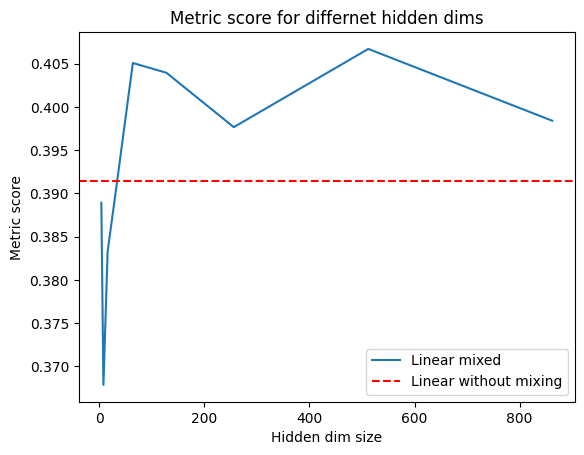

In [11]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(d_models, scores, label="Linear mixed")
plt.axhline(y=0.3914, color='r', linestyle='--', label="Linear without mixing")
plt.xlabel("Hidden dim size")
plt.ylabel("Metric score")
plt.title("Metric score for differnet hidden dims")
plt.legend()
plt.savefig(f'metric.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='r', capsize=5, capthick=2)